pm10     0
pm2.5    0
dtype: int64
입력 시퀀스 X:
[[[57.]
  [68.]
  [59.]
  [62.]
  [57.]]

 [[68.]
  [59.]
  [62.]
  [57.]
  [54.]]

 [[59.]
  [62.]
  [57.]
  [54.]
  [64.]]

 ...

 [[21.]
  [21.]
  [22.]
  [22.]
  [19.]]

 [[21.]
  [22.]
  [22.]
  [19.]
  [20.]]

 [[22.]
  [22.]
  [19.]
  [20.]
  [20.]]]
예측 대상 y:
[54. 64. 43. ... 20. 20. 21.]
Epoch 1/5


c:\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11087/11087 - 26s - 2ms/step - loss: 461.7165 - val_loss: 416.5050
Epoch 2/5
11087/11087 - 24s - 2ms/step - loss: 204.1893 - val_loss: 268.4319
Epoch 3/5
11087/11087 - 23s - 2ms/step - loss: 176.6538 - val_loss: 210.9237
Epoch 4/5
11087/11087 - 24s - 2ms/step - loss: 162.5349 - val_loss: 183.2872
Epoch 5/5
11087/11087 - 24s - 2ms/step - loss: 153.5217 - val_loss: 165.1290
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
입력 데이터: [1 5 1]
예측 값: 6.3630958
1386/1386 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


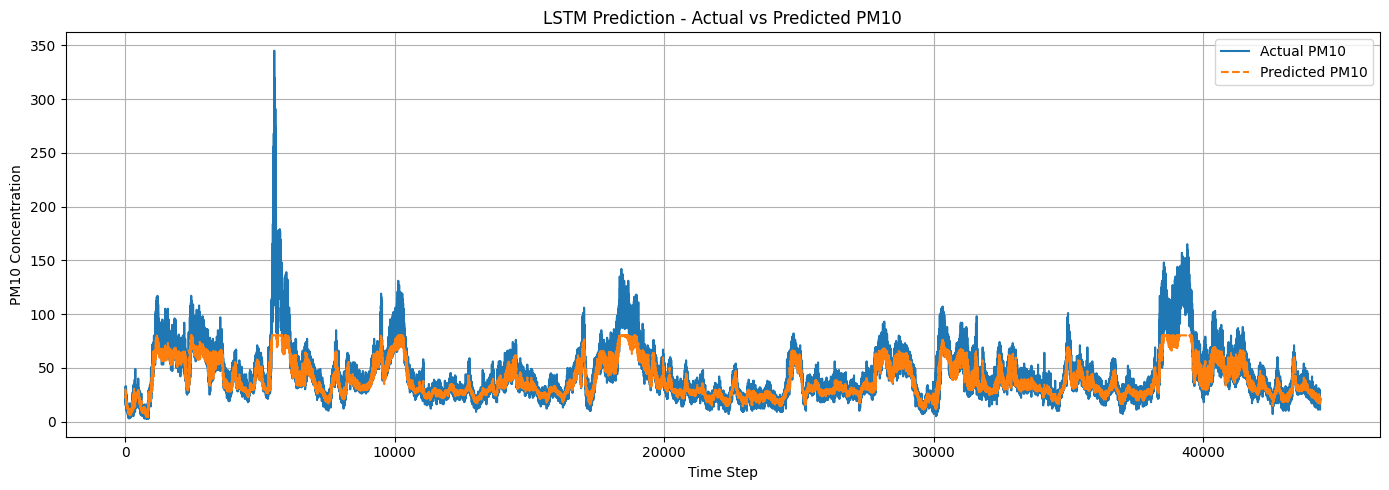

In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import numpy as np
import os
from sqlalchemy import create_engine, text
import pymysql
import sqlalchemy

# 1. 데이터 로드 : "dataset/seoul_pm10.csv"   ==> encoding='cp949' 유의
# 2. 날짜 변환 및 결측치 처리 : to_datetime
# 3. 서울 지역별 원핫 인코딩
# 4. LSTM 모델에 적합한 시퀀스 데이터셋 함수 생성
# 5. 데이터셋 분리 (학습 데이터, 테스트 데이터)
# 6. LSTM 모델 생성
# 7. 모델 컴파일 및 학습
# 8. 예측 결과 시각화

data = pd.read_csv('./dataset/seoul_pm10.csv', encoding="CP949")
data.head()

data['date'] = pd.to_datetime(data['date'])
cleaned = data[["pm10", "pm2.5"]].dropna()
# print(data.isna().sum())
print(cleaned.isna().sum())

data = pd.get_dummies(data, columns=['area'], drop_first=True)
data.head()

def create_squence(data_column, seq_length):
    X, y = [], []
    for i in range(len(data_column) - seq_length):
        X.append(data_column[i: i + seq_length])
        y.append(data_column[i + seq_length])
    return np.array(X), np.array(y)

# 'pm10' 열만 시퀀스로 만들기
pm10_data = cleaned['pm10'].values  # numpy array로 변환
seq_length = 5
X, y = create_squence(pm10_data, seq_length)
X = X.reshape((X.shape[0], X.shape[1], 1))

print("입력 시퀀스 X:")
print(X)
print("예측 대상 y:")
print(y)

# 데이터 분리
train_size = int(len(X) * 0.8)  # 80% 학습 데이터
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#모델 구성
# 2. LSTM 모델 정의
model = Sequential([
    LSTM(10, input_shape=(seq_length, 1)),  # LSTM 레이어 (유닛: 10)
    Dense(1)  # 출력 레이어
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습 및 history 저장
history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# 4. 예측 테스트
test_input = np.array([1, 5, 1]).reshape(1, -1)  # 입력 예시
predicted_value = model.predict(test_input)

# 결과 출력
print("입력 데이터:", test_input.flatten()) # flatten함수 : [[1,2],[3,4]] --> [1,2,3,4]
print("예측 값:", predicted_value[0][0])

# 테스트셋 전체에 대해 예측
y_pred = model.predict(X_test)


# 예측 결과 시각화
plt.figure(figsize=(14, 5))
plt.plot(y_test, label='Actual PM10')
plt.plot(y_pred, label='Predicted PM10', linestyle='--')
plt.title('LSTM Prediction - Actual vs Predicted PM10')
plt.xlabel('Time Step')
plt.ylabel('PM10 Concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()